In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import math
import logging

# Configure logging
logging.basicConfig(
    level=logging.WARNING,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    force=True
)
logger = logging.getLogger(__name__)

In [2]:
# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.58MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 57.3kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:06<00:00, 243kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.96MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



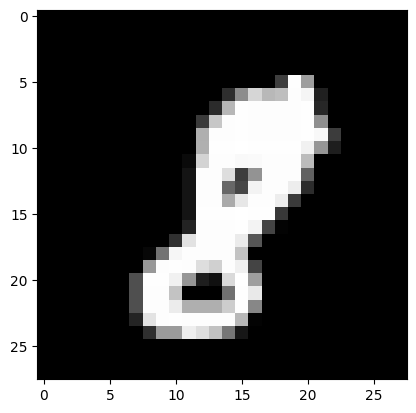

In [4]:
data_iter = iter(trainloader)
images, labels = next(data_iter)

images.shape

test_image = images[0].numpy().squeeze()
logger.info(f'image shape = {test_image.shape}')
plt.imshow(test_image, cmap='gray')
plt.show()

In [5]:
class custom_conv_2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super(custom_conv_2d, self).__init__()

        # Handle both int and tuple inputs
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        if isinstance(stride, int):
            stride = (stride, stride)
        if isinstance(padding, int):
            padding = (padding, padding)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        weight_shape = (out_channels, in_channels, *kernel_size)
        weight = torch.empty(weight_shape)
        logger.info(f"weights shape: {weight.shape}")
        nn.init.kaiming_uniform_(weight, a=math.sqrt(5))

        # Create trainable parameters
        self.weight = nn.Parameter(weight)
        self.bias = nn.Parameter(torch.zeros(out_channels)) if bias else None

    def _apply_padding(self, x):
        if self.padding[0] == 0 and self.padding[1] == 0:
            return x

        padding_shape = (
            x.shape[0],
            x.shape[1],
            x.shape[2] + 2 * self.padding[0],
            x.shape[3] + 2 * self.padding[1]
        )
        output = torch.zeros(padding_shape, device=x.device)
        output[
            :,
            :,
            self.padding[0]:self.padding[0] + x.shape[2],
            self.padding[1]:self.padding[1] + x.shape[3]
        ] = x

        # test_image = output[0].detach().numpy().squeeze()
        # print(test_image.shape)
        # plt.imshow(test_image, cmap='gray')
        # plt.show()


        return output

    def forward(self, x):
        # Apply padding
        x_padded = self._apply_padding(x)

        # Calculate output dimensions
        height = (x_padded.shape[2] - self.kernel_size[0]) // self.stride[0] + 1
        width = (x_padded.shape[3] - self.kernel_size[1]) // self.stride[1] + 1

        # Initialize output tensor
        output = torch.zeros(x.shape[0], self.out_channels, height, width, device=x.device)

        # Perform convolution operation manually
        for b in range(x.shape[0]):  # Iterate over batch
            for c_out in range(self.out_channels):  # Iterate over output channels
                for h in range(height):  # Iterate over height of the output
                    h_start = h * self.stride[0]
                    for w in range(width):  # Iterate over width of the output
                        w_start = w * self.stride[1]

                        # Extract the input patch for all input channels
                        patch = x_padded[
                            b, :,  # Batch
                            h_start:h_start + self.kernel_size[0],  # Height slice
                            w_start:w_start + self.kernel_size[1]   # Width slice
                        ]

                        # Perform element-wise multiplication with kernel and sum
                        output[b, c_out, h, w] = torch.sum(
                            patch * self.weight[c_out]
                        )

        # Add bias if it exists
        if self.bias is not None:
            output += self.bias.view(1, -1, 1, 1)

        logger.info(f'output shape = {output.shape}')
        return output

    def __repr__(self):
        return (f'in_channels={self.in_channels}, '
                f'out_channels={self.out_channels}, '
                f'kernel_size={self.kernel_size}, '
                f'stride={self.stride}, '
                f'padding={self.padding}')

In [6]:
layer = custom_conv_2d(in_channels=1, out_channels=8, kernel_size=3, padding=True)
layer.forward(images[0:2, :, :, :])
print(layer)

in_channels=1, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=(True, True)


In [ ]:
class custom_CNN(nn.Module):
    def __init__(self):
        super(custom_CNN, self).__init__()
        self.conv1 = custom_conv_2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = custom_conv_2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST digits

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        logger.info(f"x shape after 1st conv = {x.shape}")
        logger.info(f"Completed")
        x = self.pool(torch.relu(self.conv2(x)))
        logger.info(f"x shape after 2nd conv = {x.shape}")
        x = x.view(-1, 64 * 7 * 7)  # Flatten the output
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Initialize the model, loss function, and optimizer
model = custom_CNN().to(device)  # Move model to GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Train the model
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    temp_var = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        temp_var += 1
        logger.info(f"Epoch [{temp_var+1}], Loss: [{running_loss:.4f}]")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

# Evaluate the model
model.eval()
correct = 0
total = 0

# Ideal Code

```python
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST digits

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten the output
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Preprocessing and DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
model = CNN().to(device)  # Move model to GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

# Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')
```